In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import healpy as hp
from tqdm import tqdm_notebook as tqdm
import matplotlib
from matplotlib import rcParams
import pandas as pd
from scipy import integrate, optimize
from scipy.stats import chi2, norm
import emcee
from iminuit import Minuit
import pymultinest
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [2]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (10/1.2,8/1.2)
rcParams['legend.fontsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [3]:
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

In [4]:
sys.path.append("../DMFiles/")
import particle as pa
from units import *
from constants import *

In [5]:
data_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/fermi_data/"
# templates_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/templates_example/"

In [6]:
fermi_data = np.load(data_dir+'fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load(data_dir+'fermidata_exposure.npy')

dif = np.load(data_dir+'template_dif.npy')
iso = np.load(data_dir+'template_iso.npy')
psc = np.load(data_dir+'template_psc.npy')
# psc = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/PS-Maps/ps_map_et3.npy')[ebin]
bub = np.load(data_dir+'template_bub.npy')
dsk = np.load(data_dir+'template_dsk.npy')
# nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')*fermi_exposure
nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')*fermi_exposure
ps_mask = np.load(data_dir+'fermidata_pscmask.npy')

In [7]:
x_counts, y_counts, error_L, error_H, x_errors_L, x_errors_H = \
[np.array([  1.36887451e-10,   2.56502091e-10,   4.80638086e-10,
          9.00628020e-10,   1.68761248e-09,   3.16227766e-09,
          5.92553098e-09,   1.11033632e-08,   2.08056754e-08,
          3.89860370e-08,   7.30527154e-08]),
 np.array([  1.04000127e+08,   1.83397053e+08,   9.65856820e+07,
          1.51198295e+07,   4.76804443e+06,   9.78677656e+05,
          2.08916332e+05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 np.array([  2.14237668e+07,   2.08831658e+07,   1.10708578e+07,
          3.18362798e+06,   1.29929969e+06,   4.21069315e+05,
          1.34538182e+05,  -5.57461814e-04,  -2.97500603e-04,
         -1.58767124e-04,  -8.47292389e-05]),
 np.array([  2.63822671e+07,   2.34164673e+07,   1.24232945e+07,
          3.93887993e+06,   1.71404939e+06,   6.58746511e+05,
          2.74201404e+05,   1.02159419e+05,   5.45194091e+04,
          2.90953689e+04,   1.55273233e+04]),
 np.array([  3.68874510e-11,   6.91203483e-11,   1.29518913e-10,
          2.42694796e-10,   4.54765736e-10,   8.52147960e-10,
          1.59676969e-09,   2.99205487e-09,   5.60656455e-09,
          1.05056783e-08,   1.96857231e-08]),
 np.array([  5.04942913e-11,   9.46170829e-11,   1.77295138e-10,
          3.32218719e-10,   6.22517224e-10,   1.16648362e-09,
          2.18577733e-09,   4.09574765e-09,   7.67468330e-09,
          1.43809553e-08,   2.69472846e-08])]

In [8]:
GCE_options = [0,1]
GCE_tags = ["","_with_GCE_ps"]

In [9]:
xsecs_inj = [1e-26,1e-25,1e-24,1e-23]

In [10]:
templates_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/templates_example/"

In [11]:
best_fit_norms = np.load(templates_dir+"best_fit_norms_band_2_ring_30.npy")
dif_bf = np.load(templates_dir+"dif_band_2_ring_30.npy")
iso_bf = np.load(templates_dir+"iso_band_2_ring_30.npy")
psc_bf = np.load(templates_dir+"psc_band_2_ring_30.npy")
bub_bf = np.load(templates_dir+"bub_band_2_ring_30.npy")
dsk_bf = np.load(templates_dir+"dsk_band_2_ring_30.npy")

In [12]:
best_fit_bkg = dif_bf+iso_bf+psc_bf+bub_bf+dsk_bf

In [13]:
def CDF(dxvals,pofx):
    yvals = pofx*dxvals
    sortxvals = np.argsort(yvals)
    yvals = yvals[sortxvals]
    return sortxvals,np.cumsum(yvals)

def PDFSample(xvals,sortxvals,cdf,samples):
    unidraw = np.random.uniform(high=cdf[-1], size=samples)
    cdfdraw = np.searchsorted(cdf, unidraw)
    cdfdraw = sortxvals[cdfdraw]
    return xvals[cdfdraw]

In [14]:
def dNdF_2break(A,n1,n2,n3,Fb1,Fb2,F):
    if F >= Fb1:
        return A*(F/Fb1)**(-n1)
    elif F >= Fb2:
        return A*(F/Fb1)**(-n2)
    else:
        return A*(Fb2/Fb1)**(-n2)*(F/Fb2)**(-n3)

In [15]:
analysis_mask_base = cm.make_mask_total(band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=30)

In [16]:
analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 

In [17]:
# Jfac_map_NFW = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')
# Jfac_map_NFW = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')

In [18]:
smoothed_nfw = np.load("/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/JfactorSmoothed/SGH_Jfactor_map_NFW_gamma_1.2_smoothed.npy")

In [19]:
Jfac_map_NFW = smoothed_nfw[10]
nfw = smoothed_nfw[10]*fermi_exposure

In [20]:
ebins = 2*np.logspace(-1,3,41)#[7:39+2]

## 1-break scans

In [21]:
iGCE = 1
psf_king = 1

In [22]:
n1 = nptfit.NPTF(work_dir="../",tag="king/scan_data_1bk")
n1.load_data(fermi_data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
# analysis_mask = analysis_mask_base > 0
n1.load_mask(analysis_mask)

n1.add_template(dif, 'dif')
n1.add_template(iso, 'iso')
n1.add_template(psc, 'psc')
n1.add_template(bub, 'bub')
n1.add_template(dsk, 'dsk')
n1.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n1.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n1.add_template(nfw/rescale, 'nfw_ps', units='PS')
n1.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [23]:
###########
# 1-break #
###########

n1.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n1.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n1.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n1.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n1.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n1.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n1.add_non_poiss_model('iso_ps',
                      ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$'],
                      [[-10,2],[2.05,15.],[-2,1.95],[-2,2]],
                      [True,False,False,True])

n1.add_non_poiss_model('dsk_ps',
                      ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$'],
                      [[-10,2],[2.05,15.],[-2,1.95],[-2,2]],
                      [True,False,False,True])

if GCE_options[iGCE]:
    n1.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$'],
                          [[-10,2],[2.05,15.],[-2,1.95],[-2,2]],
                          [True,False,False,True])
    
if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n1.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 18


In [24]:
n1.load_scan()

  analysing data from ../chains/king/scan_data_1bk/.txt


In [25]:
an1 = dnds_analysis.Analysis(n1)

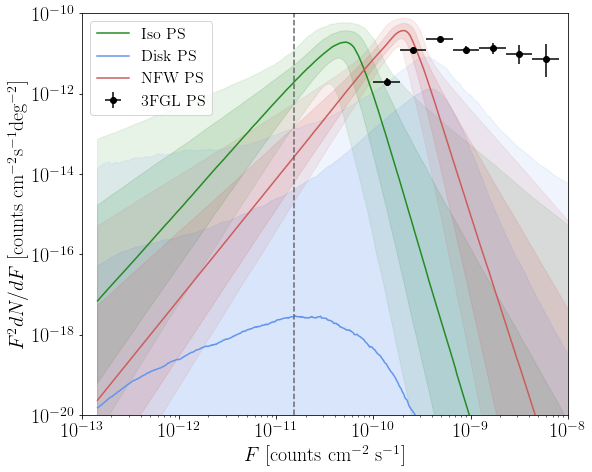

In [120]:
an1.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an1.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an1.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an1.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an1.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an1.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an1.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an1.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an1.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.tight_layout()
# plt.savefig('plots/data/kingPSF/F2dNdF_IG_1break_masked.pdf')

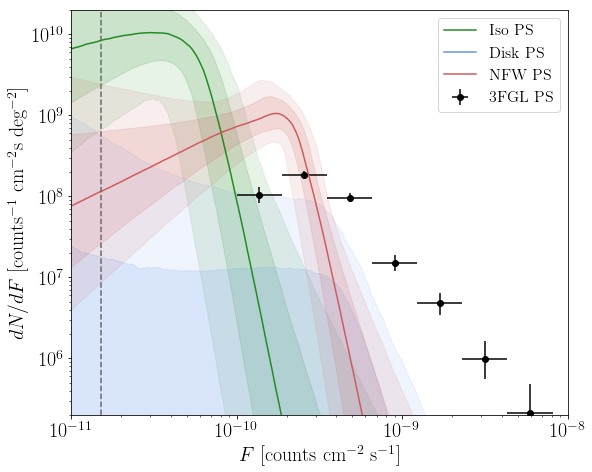

In [121]:
an1.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=0,label='Iso PS')
an1.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=0)
an1.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=0)

an1.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=0,label='Disk PS')
an1.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=0)
an1.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=0)

if GCE_options[iGCE]:
    an1.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=0,label='NFW PS')
    an1.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=0)
    an1.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=0)

plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-11,1e-8)
plt.ylim(2e5,2e10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$dN/dF$ [counts$^{-1}$ cm$^{-2}$s deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')

plt.tight_layout()
# plt.savefig('plots/data/kingPSF/dNdF_IG_1break_masked.pdf')

In [122]:
# an1.make_triangle()
# plt.savefig('plots/data/kingPSF/corner_IG_1break_masked.pdf')

## 2-break scans

In [26]:
iGCE = 1
psf_king = 1

In [27]:
n2 = nptfit.NPTF(work_dir="../",tag="king/scan_data_2bk4")
n2.load_data(fermi_data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
# analysis_mask = analysis_mask_base > 0
n2.load_mask(analysis_mask)

n2.add_template(dif, 'dif')
n2.add_template(iso, 'iso')
n2.add_template(psc, 'psc')
n2.add_template(bub, 'bub')

n2.add_template(dsk, 'dsk')
n2.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n2.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n2.add_template(nfw/rescale, 'nfw_ps', units='PS')
n2.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [28]:
n2.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n2.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n2.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n2.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n2.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n2.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n2.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

n2.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n2.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                          [[-10,2],[2.05,15.],[-2.95,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
                          [True,False,False,False,True,True])


pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n2.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy
The number of parameters to be fit is 24


In [29]:
n2.load_scan()

  analysing data from ../chains/king/scan_data_2bk4/.txt


In [30]:
an2 = dnds_analysis.Analysis(n2)

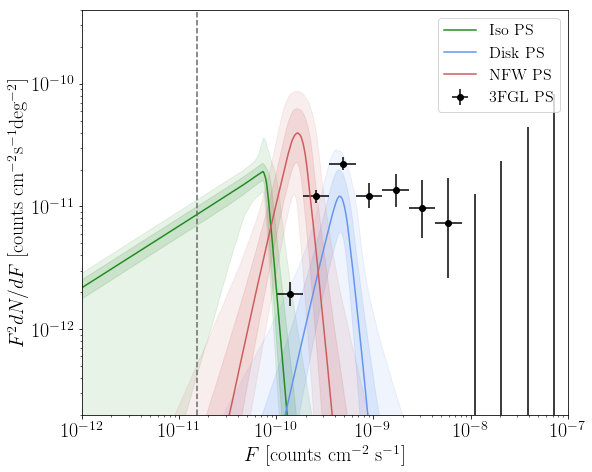

In [32]:
an2.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an2.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an2.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an2.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an2.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an2.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an2.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an2.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an2.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
# plt.xlim(1e-13,1e-8)
# plt.ylim(1e-20,1e-10)
plt.xlim(1e-12,1e-7)
plt.ylim(2e-13,4e-10)

plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
plt.savefig('plots/data/kingPSF/F2dNdF_IG_2break_masked_smsharmarange.pdf')

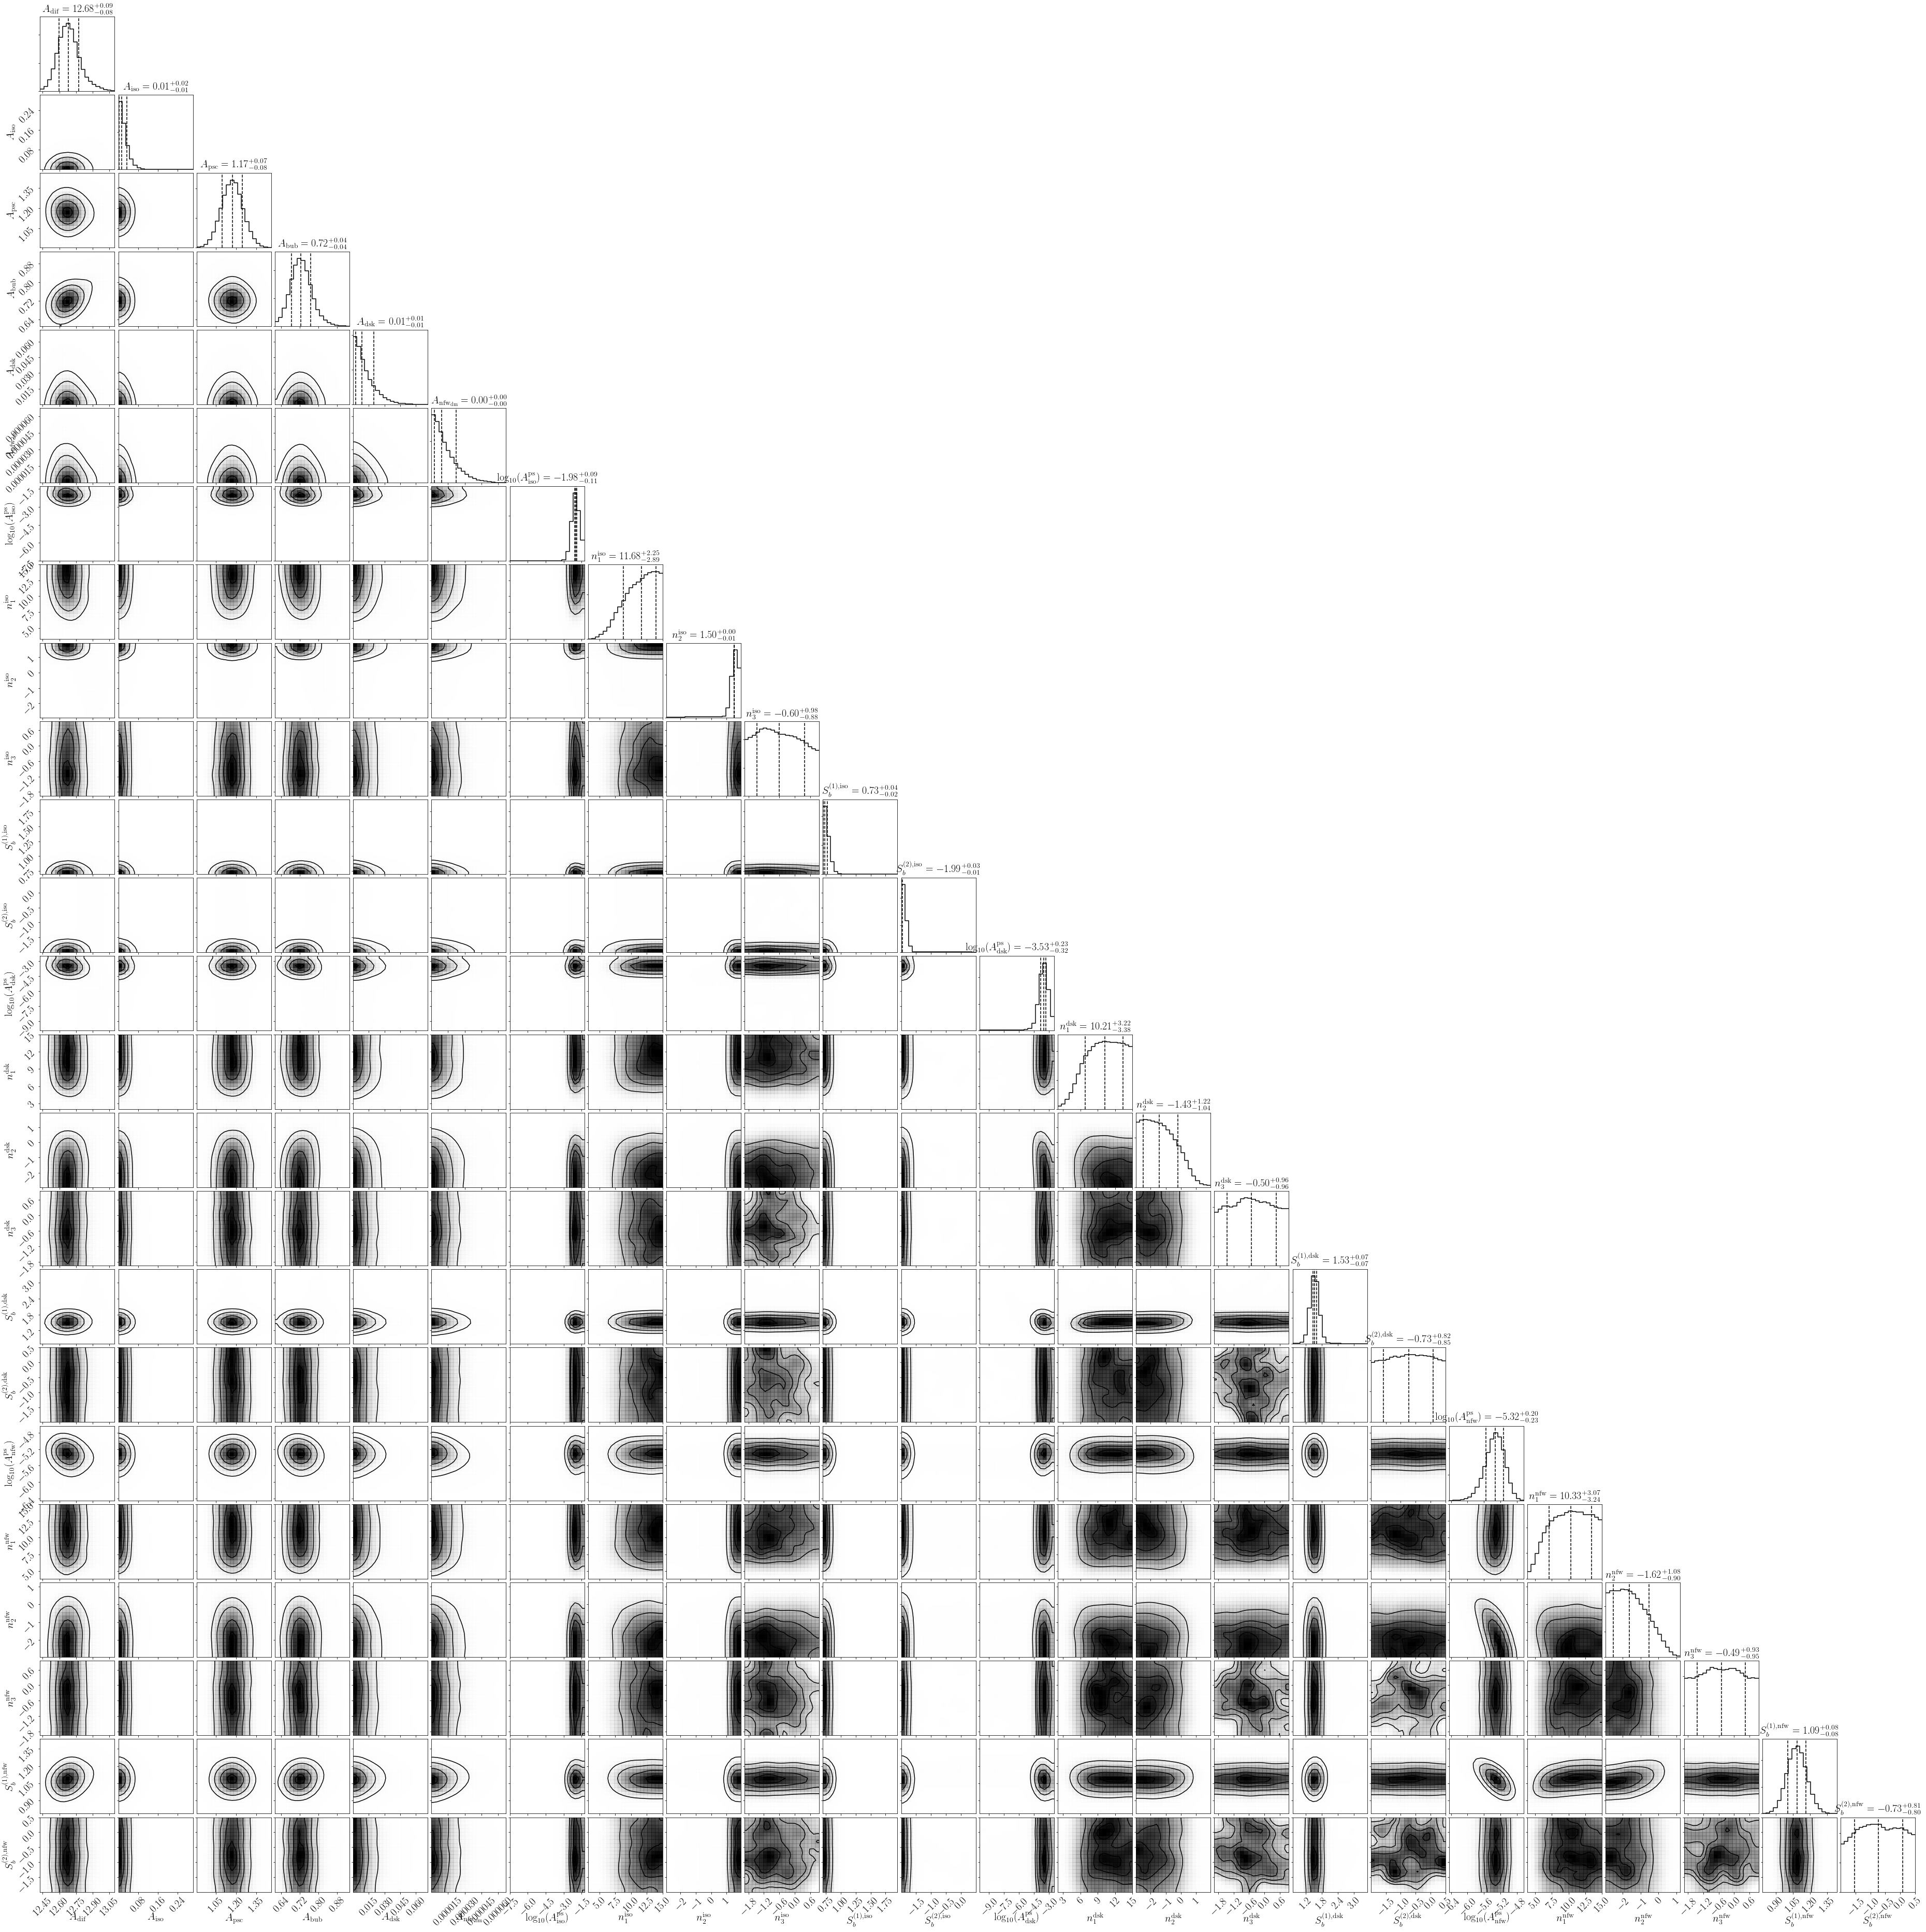

In [158]:
an2.make_triangle()
# plt.savefig('plots/data/kingPSF/corner_IG_2break_masked.pdf')

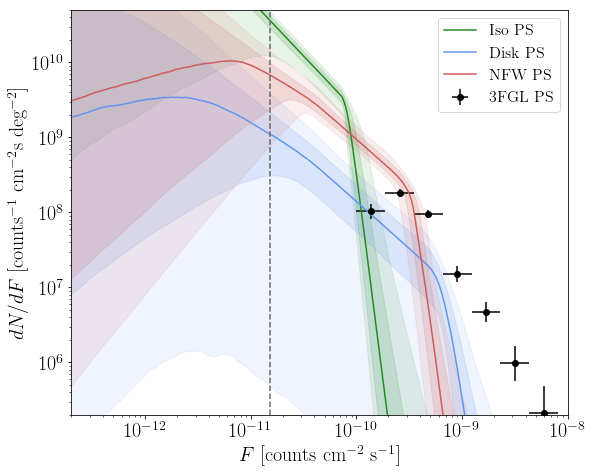

In [131]:
an2.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=0,label='Iso PS')
an2.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=0)
an2.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=0)

an2.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=0,label='Disk PS')
an2.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=0)
an2.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=0)

if GCE_options[iGCE]:
    an2.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=0,label='NFW PS')
    an2.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=0)
    an2.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=0)

plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(2e5,5e10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$dN/dF$ [counts$^{-1}$ cm$^{-2}$s deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')

plt.tight_layout()
# plt.savefig('plots/data/kingPSF/dNdF_IG_2break_masked.pdf')

## 3-break scans

In [138]:
n3 = nptfit.NPTF(work_dir="../",tag="king/scan_data_3bk3")
n3.load_data(fermi_data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
# analysis_mask = analysis_mask_base > 0
n3.load_mask(analysis_mask)

n3.add_template(dif, 'dif')
n3.add_template(iso, 'iso')
n3.add_template(psc, 'psc')
n3.add_template(bub, 'bub')
n3.add_template(dsk, 'dsk')
n3.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n3.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n3.add_template(nfw/rescale, 'nfw_ps', units='PS')
n3.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [139]:
n3.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n3.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n3.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n3.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n3.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n3.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n3.add_non_poiss_model('iso_ps',
                      ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$n_4^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$','$S_b^{(3),\mathrm{iso}}$'],
                      [[-10,2],[2.05,15.],[-1.95,1.95],[-1.95,1.95],[-15.,0.95],[0.7,2.5],[0.2,0.7],[-2,0.2]],
                      [True,False,False,False,False,True,True,True])

n3.add_non_poiss_model('dsk_ps',
                      ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$n_4^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$','$S_b^{(3),\mathrm{dsk}}$'],
                      [[-10,2],[2.05,15.],[-1.95,1.95],[-1.95,1.95],[-15.,0.95],[0.7,2.5],[0.2,0.7],[-2,0.2]],
                      [True,False,False,False,False,True,True,True])

if GCE_options[iGCE]:
    n3.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$n_4^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$','$S_b^{(3),\mathrm{nfw}}$'],
                          [[-10,2],[2.05,15.],[-1.95,1.95],[-1.95,1.95],[-15.,0.95],[0.7,2.5],[0.2,0.7],[-2,0.2]],
                          [True,False,False,False,False,True,True,True])


pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n3.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy
The number of parameters to be fit is 30


In [140]:
n3.load_scan()

  analysing data from ../chains/king/scan_data_3bk3/.txt


In [141]:
an3 = dnds_analysis.Analysis(n3)

In [142]:
# an3.make_triangle()
# plt.savefig('plots/data/kingPSF/corner_IG_3break_masked.pdf')

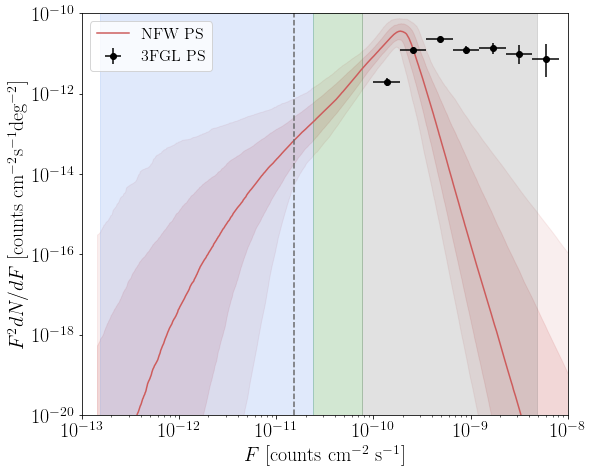

In [143]:
# an3.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
# an3.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
# an3.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

# an3.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
# an3.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
# an3.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an3.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an3.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an3.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**1.52/np.mean(fermi_exposure),ls='dotted',color='dimgray')
# plt.axvline(10**0.8/np.mean(fermi_exposure),ls='dotted',color='dimgray')
plt.axvspan(10**-2/np.mean(fermi_exposure),10**0.2/np.mean(fermi_exposure),alpha=.2,color='cornflowerblue')
plt.axvspan(10**0.2/np.mean(fermi_exposure),10**0.7/np.mean(fermi_exposure),alpha=.2,color='forestgreen')
plt.axvspan(10**0.7/np.mean(fermi_exposure),10**2.5/np.mean(fermi_exposure),alpha=.2,color='dimgray')

plt.legend()

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
# plt.savefig('plots/data/kingPSF/F2dNdF_IG_3break_masked.pdf')

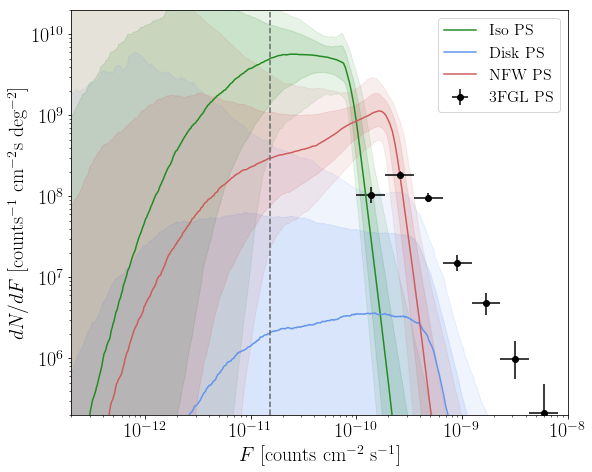

In [144]:
an3.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=0,label='Iso PS')
an3.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=0)
an3.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=0)

an3.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=0,label='Disk PS')
an3.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=0)
an3.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=0)

if GCE_options[iGCE]:
    an3.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=0,label='NFW PS')
    an3.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=0)
    an3.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=0)

plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

# plt.axvspan(10**-2/np.mean(fermi_exposure),10**0.2/np.mean(fermi_exposure),alpha=.2,color='cornflowerblue')
# plt.axvspan(10**0.2/np.mean(fermi_exposure),10**1.1/np.mean(fermi_exposure),alpha=.2,color='forestgreen')
# plt.axvspan(10**1.1/np.mean(fermi_exposure),10**2.5/np.mean(fermi_exposure),alpha=.2,color='dimgray')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(2e5,2e10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$dN/dF$ [counts$^{-1}$ cm$^{-2}$s deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')

plt.tight_layout()
# plt.savefig('plots/data/kingPSF/dNdF_IG_3break_masked.pdf')